In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

#from models.glm import GLM
#from models.tcn import TCN
#from models.sub_tcn import Sub_TCN
from models.sub_cos_tcn import Sub_Cos_TCN
#from models.sub_hist_tcn import Sub_Hist_TCN

# Hyperparameters

In [2]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
V_file = "V_diff.npy"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)

part_C_syn_e = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_e.npy")
part_C_syn_i = np.load("/media/hdd01/sklee/CA1_clust4-60/data/handsub6_C_syn_i.npy")
part_C_syn_e = torch.from_numpy(part_C_syn_e)
part_C_syn_i = torch.from_numpy(part_C_syn_i)

In [3]:
T_train = 992 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 2
sub_no = 4
two_nonlin = False
E_no = 2000
I_no = 200
T_no = 500
device = torch.device("cuda")

batch_length = 50000
batch_size = 4
iter_no = 9920*2
epoch_no = iter_no*batch_length*batch_size//T_train 

# Preprocess

In [4]:
V_train = V[:T_train].float()
V_test = V[T_train:T_train + T_test].to(device).float()

test_E_neural = E_neural[T_train:T_train+T_test].toarray()
test_I_neural = I_neural[T_train:T_train+T_test].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
C_syn_e = torch.zeros(sub_no, E_no).to(device)
C_syn_i = torch.zeros(sub_no, I_no).to(device)

for i in range(E_no):
    den = eloc[i,0]
    if den == den_idx[0]:
        C_syn_e[0,i] = 1
    elif den == den_idx[1]:
        C_syn_e[1,i] = 1
    elif den == den_idx[2]:
        C_syn_e[2,i] = 1
    elif den == den_idx[3]:
        C_syn_e[3,i] = 1

for i in range(I_no):
    den = iloc[i,0]
    if den == den_idx[0]:
        C_syn_e[0,i] = 1
    elif den == den_idx[1]:
        C_syn_e[1,i] = 1
    elif den == den_idx[2]:
        C_syn_e[2,i] = 1
    elif den == den_idx[3]:
        C_syn_e[3,i] = 1

In [6]:
"""
C_syn_e = torch.zeros(sub_no, E_no).to(device)
C_syn_e[:6] = part_C_syn_e

C_syn_i = torch.zeros(sub_no, I_no).to(device)
C_syn_i[:6] = part_C_syn_i

for i in range(E_no):
    den = eloc[i,0]
    if den == den_idx[0]:
        C_syn_e[:,i] = 0
        C_syn_e[6,i] = 1
    elif den == den_idx[1]:
        C_syn_e[:,i] = 0
        C_syn_e[7,i] = 1
    elif den == den_idx[2]:
        C_syn_e[:,i] = 0
        C_syn_e[8,i] = 1
    elif den == den_idx[3]:
        C_syn_e[:,i] = 0
        C_syn_e[9,i] = 1

for i in range(I_no):
    den = iloc[i,0]
    if den == den_idx[0]:
        C_syn_e[:,i] = 0
        C_syn_e[6,i] = 1
    elif den == den_idx[1]:
        C_syn_e[:,i] = 0
        C_syn_e[7,i] = 1
    elif den == den_idx[2]:
        C_syn_e[:,i] = 0
        C_syn_e[8,i] = 1
    elif den == den_idx[3]:
        C_syn_e[:,i] = 0
        C_syn_e[9,i] = 1
        
C_den = torch.zeros(sub_no, sub_no).to(device)
C_den[0,1:] = 1
"""

'\nC_syn_e = torch.zeros(sub_no, E_no).to(device)\nC_syn_e[:6] = part_C_syn_e\n\nC_syn_i = torch.zeros(sub_no, I_no).to(device)\nC_syn_i[:6] = part_C_syn_i\n\nfor i in range(E_no):\n    den = eloc[i,0]\n    if den == den_idx[0]:\n        C_syn_e[:,i] = 0\n        C_syn_e[6,i] = 1\n    elif den == den_idx[1]:\n        C_syn_e[:,i] = 0\n        C_syn_e[7,i] = 1\n    elif den == den_idx[2]:\n        C_syn_e[:,i] = 0\n        C_syn_e[8,i] = 1\n    elif den == den_idx[3]:\n        C_syn_e[:,i] = 0\n        C_syn_e[9,i] = 1\n\nfor i in range(I_no):\n    den = iloc[i,0]\n    if den == den_idx[0]:\n        C_syn_e[:,i] = 0\n        C_syn_e[6,i] = 1\n    elif den == den_idx[1]:\n        C_syn_e[:,i] = 0\n        C_syn_e[7,i] = 1\n    elif den == den_idx[2]:\n        C_syn_e[:,i] = 0\n        C_syn_e[8,i] = 1\n    elif den == den_idx[3]:\n        C_syn_e[:,i] = 0\n        C_syn_e[9,i] = 1\n        \nC_den = torch.zeros(sub_no, sub_no).to(device)\nC_den[0,1:] = 1\n'

# Train

In [8]:
#model = GLM(C_den, C_syn_e, C_syn_i, T_no, device)
model = Sub_Cos_TCN(C_syn_e, C_syn_i, T_no, H_no, two_nonlin, device)

#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005) # For GLM
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005) # For TCN / Sub TCN
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005) # For Cos TCN

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2541


In [9]:
score_list = []

for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred = model(batch_E_neural[:,10000:40000,:], batch_I_neural[:,10000:40000,:])
    
    loss = torch.mean((V_pred - batch_V[:,10000:40000])**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred = model(test_E_neural.unsqueeze(0)[:,10000:40000,:], test_I_neural.unsqueeze(0)[:,10000:40000,:])
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test[10000:40000].cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[10000:40000]-test_V_pred)**2).item()
        score_list.append(test_score)
                
        print(i, np.round(test_score,6),
              np.round(test_mse,6))


<ipython-input-9-c0e148135b67>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


0 -0.064414 0.064325
49 0.279746 0.036419
99 0.300974 0.035336
149 0.311062 0.034819
199 0.320675 0.034333
249 0.324374 0.034157
299 0.331796 0.033807
349 0.333616 0.03373
399 0.332562 0.033734
449 0.325031 0.03433
499 0.331545 0.033967
549 0.329742 0.033974
599 0.336464 0.033529
649 0.329962 0.033926
699 0.339225 0.033392
749 0.339371 0.033386
799 0.339164 0.033481
849 0.337551 0.033577
899 0.34077 0.033333
949 0.336235 0.033563
999 0.346621 0.033044
1049 0.342857 0.033525
1099 0.350013 0.032869
1149 0.345553 0.033113
1199 0.347393 0.033085
1249 0.355178 0.032583
1299 0.355384 0.032575
1349 0.354203 0.032931
1399 0.360825 0.032347
1449 0.361893 0.032286
1499 0.362745 0.032201
1549 0.364858 0.032095
1599 0.363246 0.032233
1649 0.374947 0.031599
1699 0.369919 0.031848
1749 0.378473 0.031478
1799 0.373547 0.031659
1849 0.369528 0.032115
1899 0.382223 0.031218
1949 0.383703 0.031142
1999 0.373121 0.032136
2049 0.387186 0.030975
2099 0.387811 0.030973
2149 0.39242 0.030703
2199 0.395245 0.

KeyboardInterrupt: 

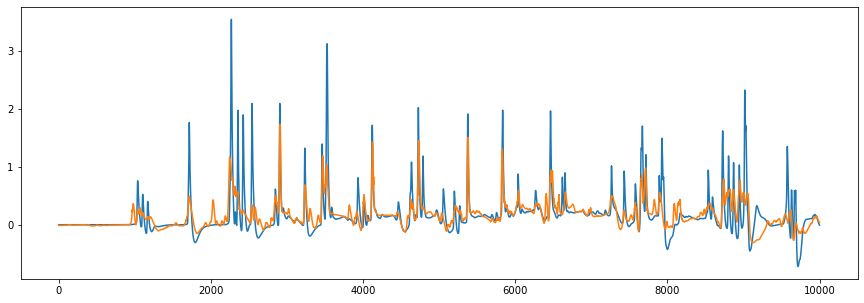

In [10]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[6000:16000])

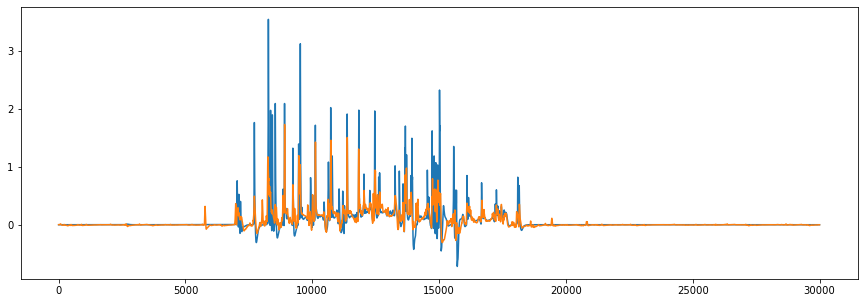

In [11]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[10000:40000])
plt.plot(test_V_pred.cpu().detach().numpy())

In [15]:
kern_basis = torch.zeros(20, T_no).to(device)
for i in range(20):
    phi = 1.5707963267948966*i
    xmin = phi - 3.141592653589793
    xmax = phi + 3.141592653589793

    x_in = torch.arange(0, T_no, 1)
    raw_cos = 3.5  * torch.log(x_in + 1 + 1e-7)

    basis = 0.5*torch.cos(raw_cos - phi) + 0.5
    basis[raw_cos < xmin] = 0.0
    basis[raw_cos > xmax] = 0.0
    kern_basis[i] = basis
    
kern_e = torch.matmul(model.W_e_layer1, kern_basis)
kern_i = torch.matmul(model.W_i_layer1, kern_basis)

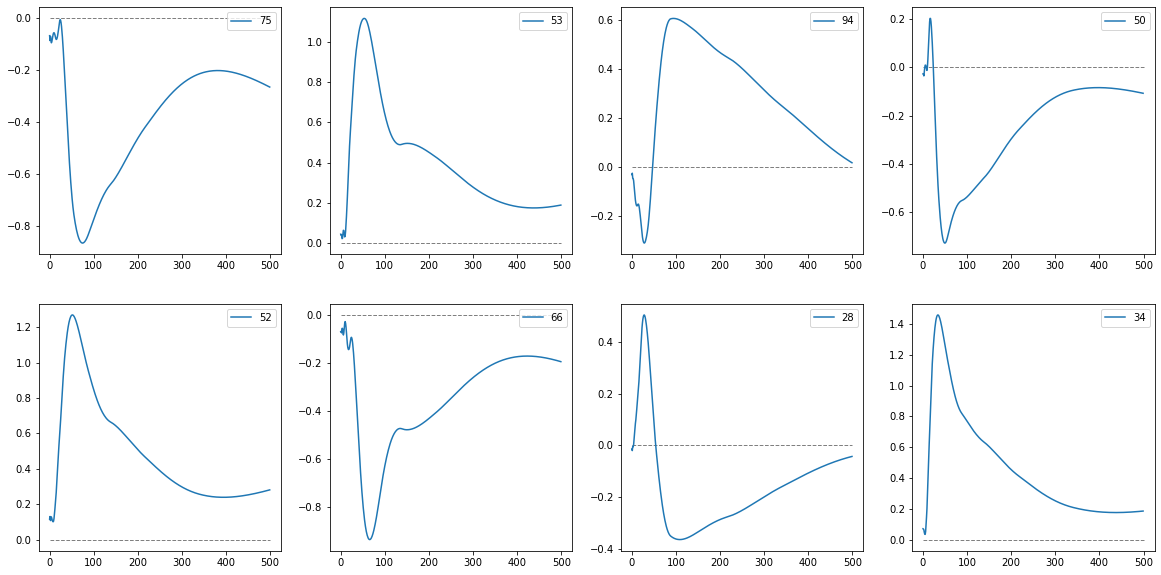

In [19]:
fig, axs = plt.subplots(nrows = H_no, ncols= sub_no, figsize = (20,10))

for i in range(H_no):
    for j in range(sub_no):
        idx = j*H_no + i
        max_t = np.argmax(np.abs(kern_e[idx].cpu().detach().numpy()))
        axs[i,j].plot(kern_e[idx].cpu().detach().numpy(), label=str(max_t))
        axs[i,j].hlines(y=0, xmin=0, xmax=T_no, linewidth=1, linestyle="--", color="gray")
        axs[i,j].legend()